In [2]:
# TODO:
#  1. [DONE ???] I switched from overfitting to bias, now is bias, I need more weights until the range returns to -180, 180
#.      - add the tanh again at the en
#.      - check the distributions of the scores, are there less negsatives? => balance the dataset by sampling
#.      - is the mean of the true scores shifted, try stsandardizing the inputs and undoing it with the outputs. This is done AFTER the scaling to [-1. 1]
#  2. [DONE] normalize inputs and multiply the outputs, remove the lambda layer
#  3. [DONE] keras dtype policy 16 bit
#  4. can we train an encoder-decoder in autoencoder setup to get the embeddings? Would that have the same dimensionality problem?
#  5. [DONE] add the chemical signature of the compounds and chem features
#  6. CV for evaluation and fix the rmrmse performance
#  7. introduce gene features (biology)

In [3]:
! cd ~
! pwd
! mkdir -p scp/model
# ! cp /kaggle/input/open-problems-single-cell-perturbations/* /home/jovyan/kaggle/working/scp/input
# ! ls -l /content/drive/MyDrive/as/study/biotec/kaggle/scp/input
! ls -l ../kaggle/input/open-problems-single-cell-perturbations

/home/jovyan/workspace
total 5354032
-rw-rw-r-- 1 jovyan jovyan  100924456 Nov  9 00:05 adata_excluded_ids.csv
-rw-rw-r-- 1 jovyan jovyan   37227289 Sep 13 14:53 adata_obs_meta.csv
-rw-rw-r-- 1 jovyan jovyan 1761529901 Sep 13 14:53 adata_train.parquet
-rw-rw-r-- 1 jovyan jovyan  450105344 Oct 27 18:38 adata_train.parquet.F249d036
-rw-rw-r-- 1 jovyan jovyan   92135550 Sep 13 14:53 de_train.parquet
-rw-rw-r-- 1 jovyan jovyan       6723 Sep 13 14:53 id_map.csv
-rw-rw-r-- 1 jovyan jovyan     943757 Sep 13 14:53 multiome_obs_meta.csv
-rw-rw-r-- 1 jovyan jovyan 2555628667 Sep 13 14:53 multiome_train.parquet
-rw-rw-r-- 1 jovyan jovyan  461373440 Oct 27 18:38 multiome_train.parquet.CD29e8F0
-rw-rw-r-- 1 jovyan jovyan   13075170 Sep 13 14:53 multiome_var_meta.csv
-rw-rw-r-- 1 jovyan jovyan   18711844 Sep 13 14:53 sample_submission.csv


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# ! kaggle competitions download -c open-problems-single-cell-perturbations
# ! unzip open-problems-single-cell-perturbations.zip -d /home/jovyan/kaggle/working/scp/input
# ! rm open-problems-single-cell-perturbations.zip
# ! ls -l /home/jovyan/kaggle/working/scp/input/*

# Library installations and impots
* * *

In [6]:
# !pip install numpy==1.23.5
# !pip uninstall tensorflow -y
# !pip install tensorflow

In [7]:
import numpy as np
import pandas as pd
import os
import datetime
import json
from collections import defaultdict, OrderedDict

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.python.client import device_lib

# set the dtype policy
# mixed_precision.set_global_policy('mixed_float16')

In [8]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(17)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [9]:
# check cuda
tf.test.is_built_with_cuda(), tf.config.list_physical_devices('GPU')

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

# Your output is probably something like ['/device:CPU:0']
# It should be ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


2023-11-28 06:19:56.273127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 06:19:56.277273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 06:19:56.277532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 06:19:56.278284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
# constants
# train_path = '/content/drive/MyDrive/as/study/biotec/kaggle/scp'
# model_path = '/content/drive/MyDrive/as/study/biotec/kaggle/scp/model'
data_path = '../kaggle/input/open-problems-single-cell-perturbations'
model_path = './scp/model'
intermediate_path = './scp/intermediate'

OUTPUT_SCALE = 180

EPOCHS = 500
BATCH_SIZE = 1024
PATIENCE = 100
LR_PLATEAU_PATIENCE = 20
LR_PLATEAU_FACTOR = 0.1
VALIDATION_SPLIT = 0.01

# Read training data
* * *

In [11]:
train_df = pd.read_parquet(f"{data_path}/de_train.parquet")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Columns: 18216 entries, cell_type to ZZEF1
dtypes: bool(1), float64(18211), object(4)
memory usage: 85.3+ MB


In [12]:
# create name-id mappings for embeddings
name_to_id = lambda names: {name:id for id, name in enumerate(sorted(set(names)))}
name_to_id_maps = {
    'cell_type': name_to_id(train_df['cell_type'].values),
    'sm_name': name_to_id(train_df['sm_name'].values),
}
gene_names = list(train_df.columns[5:])
name_to_id_maps['gene_name'] = name_to_id(gene_names)

# save for use in prediction
with open(f'{intermediate_path}/name_to_id_maps_for_embeddings.txt', 'w') as file:
     file.write(json.dumps(name_to_id_maps)) # use `json.loads` to do the reverse

In [13]:
# reshape train_df
_ = train_df.set_index(['cell_type', 'sm_name'], inplace=True)
train_df.drop(['sm_lincs_id', 'SMILES', 'control'], inplace=True, axis=1)
print(train_df.shape)
df_train = train_df.dropna()
print(train_df.shape)
train_df.columns[:5]
train_df.head()

(614, 18211)
(614, 18211)


,,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,sm_name,,,,,,,,,,,,,,,,,,,,,
NK cells,Clotrimazole,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
T cells CD4+,Clotrimazole,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
T cells CD8+,Clotrimazole,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
T regulatory cells,Clotrimazole,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
NK cells,Mometasone Furoate,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [14]:
print(train_df.values.min(), train_df.values.max())
OUTPUT_SCALE = int(round((train_df.values.max() - train_df.values.min()))/2)
print(OUTPUT_SCALE)

-180.5192016034818 179.32417689610105
180


In [15]:
name_to_id_maps['cell_type']['NK cells'], name_to_id_maps['cell_type']

(2,
 {'B cells': 0,
  'Myeloid cells': 1,
  'NK cells': 2,
  'T cells CD4+': 3,
  'T cells CD8+': 4,
  'T regulatory cells': 5})

# Read features
* * *

In [41]:
fp_path = f"{intermediate_path}/fingerprints.csv"
fp_df = pd.read_csv(fp_path)
print(f'Read {fp_df.shape[0]} small molecule fingerprints from path:\n{fp_path}')
fp_df['fp'] = fp_df['fingerprint'].apply(lambda x: list(map(int, x[1:-1].split(','))))
fp_df.drop(columns=['fingerprint'], inplace=True)
name_to_fp = {row[0]: row[1] for row in fp_df.values}
print(name_to_fp['Clotrimazole'])
fp_df

Read 146 small molecule fingerprints from path:
./scp/intermediate/fingerprints.csv
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0]


,sm_name,fp
0,Clotrimazole,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Mometasone Furoate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Idelalisib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Vandetanib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Bosutinib,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
141,CGM-097,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
142,TGX 221,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
143,Azacitidine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
144,Atorvastatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [42]:
ro5_path = f"{intermediate_path}/ro5_descriptors.csv"
ro5_df = pd.read_csv(ro5_path)
print(f'Read {ro5_df.shape[0]} small molecule descriptors from path:\n{ro5_path}')
ro5_df

Read 146 small molecule descriptors from path:
./scp/intermediate/ro5_descriptors.csv


,sm_name,MW,HBA,HBD,LogP,pass_ro5
0,Clotrimazole,344.845,2,0,5.37670,True
1,Mometasone Furoate,521.437,6,1,4.86920,True
2,Idelalisib,415.432,8,2,3.75430,True
3,Vandetanib,475.362,6,1,5.00420,True
4,Bosutinib,530.456,8,1,5.19038,False
...,...,...,...,...,...,...
141,CGM-097,659.271,8,0,6.58350,False
142,TGX 221,364.449,6,1,3.01262,True
143,Azacitidine,244.207,9,5,-3.16800,True
144,Atorvastatin,558.650,7,4,6.31360,False


In [43]:
# name_to_ro5 = {sm_name: ro5_df[['MW', 'HBA', 'HBD', 'LogP', 'pass_ro5']]}
ro5_df['pass_ro5'] = ro5_df['pass_ro5'].astype('int')
ro5_df['LogP'] = ro5_df['LogP'].round(4)
name_to_ro5 = {row[0]: row[1:] for row in ro5_df.values}
name_to_ro5['Clotrimazole']

array([344.845, 2, 0, 5.3767, 1], dtype=object)

# Modeling considerations
* * *
## Input
- cell_type: integer (5 categories)
- sm_name: integer (144 categories)
- gene_name: integer (18,000 categories)
- ro5: array of shape=[5], float. Chemical features of the sm.
- fp: fingerprints (maccs keys). 167 binary flags. 

## Ignored inputs
- control: this is a dependent variable, it can be inferred from sm_name.  
- SMILES:  temporarily not used, we may add qhemical features at a later stage.  
  
## Output
- differential gene expression: real number
  
## Representation:
- We need to encode some of the inputs with dense vectors, given the cardinality of the gene_name input, we can't use sparse one-hot vectors (aka dummy variables) because it would take too much memory.
  
## Deep Learning Model
- The categorical inputs are mapped to integer ids. Then, each id is, in tern, mapped to a short dense vector, which is initialized randomly and trained with the gradient backpropagation method.  The training gradually changes these vectors generating numeric differences between them that mirror the differences between the categorical inputs that they represent. This is known in deep learning as an "embedding layer".  
- The output is a real number between -30 and 30, and the exploratory data analysis has shown that the distribution of the outputs is approximately normal with mean 0, therefore the output is modeled with a hyperbolic tangent function, which outputs a range [-1, 1], multiplied by a constant of value 30.    


# Create the feature matrix for training
* * *
The feature matrix is a mapping with a tuple feature ids as key and the true label as value.
This mapping has two uses, first it in training and later for computing the rmse of the predictions.


In [45]:
feature_matrix_train = OrderedDict()

# get columns as lists for code clarity
cell_types, sm_names = zip(*train_df.index.tolist())
de_values = train_df[gene_names].values

#
for cell_type, sm_name, diff_expressions in zip(cell_types, sm_names, de_values):
  cell_type_id = name_to_id_maps['cell_type'][cell_type]
  sm_name_id = name_to_id_maps['sm_name'][sm_name]
  ro5 = name_to_ro5[sm_name]
  fp = name_to_fp[sm_name]

  # gene differential expression columns
  for gene_name, diff_expression in zip(gene_names, diff_expressions):
    gene_name_id = name_to_id_maps['gene_name'][gene_name]
    feature_matrix_train[(cell_type_id, sm_name_id, gene_name_id, *ro5, *fp)] = diff_expression

print(f'cell_types.shape: {len(set(cell_types))}')
print(f'sm_names.shape: {len(set(sm_names))}')

cell_types.shape: 6
sm_names.shape: 146


In [47]:
# list(feature_matrix_train.keys())[:2]

# Define the neural network
* * *

In [49]:
# define the NN
# feed forward regressor with a trainable
# embedding layer that accepts 4 integers,
# and a single-unit output layer

input_cell = Input(shape=(1,), dtype='int16')
input_drug = Input(shape=(1,), dtype='int16')
input_gene = Input(shape=(1,), dtype='int16')
input_drug_ro5 = Input(shape=(1,5,), dtype='float32')
input_drug_fp = Input(shape=(1,167,), dtype='float32')

embedding_cell = Embedding(input_dim=len(name_to_id_maps['cell_type']), output_dim=32,
                        embeddings_regularizer=tf.keras.regularizers.L2(0.01))(input_cell)

embedding_drug = Embedding(input_dim=len(name_to_id_maps['sm_name']), output_dim=8,
                        embeddings_regularizer=tf.keras.regularizers.L2(0.01))(input_drug)

embedding_gene = Embedding(input_dim=len(name_to_id_maps['gene_name']), input_length=1, output_dim=512,
                        embeddings_regularizer=tf.keras.regularizers.L2(0.01))(input_gene)

concatenated = Concatenate()([embedding_cell, embedding_drug, embedding_gene, input_drug_ro5, input_drug_fp])

# dense layers 
middle_layers = Dense(256)(concatenated)
middle_layers = BatchNormalization()(middle_layers)
middle_layers = LeakyReLU(.15)(middle_layers)
middle_layers = Dropout(.2)(middle_layers)

middle_layers = Dense(128)(middle_layers)
middle_layers = BatchNormalization()(middle_layers)
middle_layers = LeakyReLU(.15)(middle_layers)
middle_layers = Dropout(.2)(middle_layers)

middle_layers = Dense(64)(middle_layers)
middle_layers = BatchNormalization()(middle_layers)
middle_layers = LeakyReLU(.15)(middle_layers)
# middle_layers = Dropout(.2)(middle_layers)

middle_layers = Dense(64)(middle_layers)
middle_layers = BatchNormalization()(middle_layers)
middle_layers = LeakyReLU(.15)(middle_layers)
# middle_layers = Dropout(.2)(middle_layers)

middle_layers = Dense(32)(middle_layers)
middle_layers = BatchNormalization()(middle_layers)
middle_layers = LeakyReLU(.15)(middle_layers)

# output
output = Dense(1)(middle_layers)
# output = tanh(output)
# output = Lambda(lambda x: x * OUTPUT_SCALE)(output)

regressor = Model(inputs=[input_cell, input_drug, input_gene, input_drug_ro5, input_drug_fp], outputs=[output])

# Compile the regressor
regressor.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 32)        192         ['input_6[0][0]']                
                                                                                            

# Training
* * *

In [50]:
# ! rm -rf .ipynb_checkpoints

In [51]:
! rm -rf .mdl_wts*

In [52]:
checkpoint_filepath = '.mdl_wts/'
if os.path.exists(checkpoint_filepath):
    print(f'Loading model weights from: {checkpoint_filepath}')
    regressor.load_weights(checkpoint_filepath)

In [53]:
! mkdir .mdl_wts/
! ls -la

total 560
drwxrwsr-x  6 jovyan jovyan   4096 Nov 28 06:48 .
drwxr-Sr-- 19 jovyan jovyan   4096 Oct 27 23:43 ..
-rw-rw-r--  1 jovyan jovyan 239497 Oct 29 23:00 03_model_training.ipynb
-rw-rw-r--  1 jovyan jovyan 230567 Nov 28 06:48 04_model_training.ipynb
-rw-rw-r--  1 jovyan jovyan  64330 Oct 31 14:53 05_prediction.ipynb
-rw-rw-r--  1 jovyan jovyan     73 Oct 27 23:25 checkpoint
drwxrwsr-x  2 jovyan jovyan   4096 Oct 30 02:38 .ipynb_checkpoints
drwxr-sr-x  2 jovyan jovyan   4096 Nov 28 06:48 .mdl_wts
-rw-rw-r--  1 jovyan jovyan   2501 Oct 30 02:37 name_to_id_maps_for_embeddings.txt
drwxrwsr-x  3 jovyan jovyan   4096 Oct 27 16:37 neurips-2023-scripts
drwxrwsr-x  6 jovyan jovyan   4096 Oct 28 23:13 scp


In [56]:
list(feature_matrix_train.values())[:5]

[0.10472047446898534,
 -0.07752420930615231,
 -1.6255960356468964,
 -0.14454470896369243,
 0.14355468030117133]

In [58]:
# Train the regressor

# format input data as tensors
X = np.array(list(feature_matrix_train.keys())).reshape(-1,175)
y = np.array(list(feature_matrix_train.values())).reshape(-1,1) #/ OUTPUT_SCALE

mcp_save = ModelCheckpoint(checkpoint_filepath, save_best_only=True, save_weights_only=True,
                          monitor='val_loss', mode='min', verbose=1)

early_stop = EarlyStopping(patience=PATIENCE, restore_best_weights=False,
                          monitor='val_loss', mode='min', verbose=1)

reduce_lr_loss = ReduceLROnPlateau(factor=LR_PLATEAU_FACTOR, patience=LR_PLATEAU_PATIENCE, min_delta=1e-6,
                          monitor='val_loss', mode='min', verbose=1)

history = regressor.fit([X[:,0],  X[:,1],  X[:,2],  
                         X[:,3:8].reshape((-1, 1, 5)),  X[:,8:].reshape((-1, 1, 167))], y,
                        validation_split=VALIDATION_SPLIT,
                        callbacks=[mcp_save, early_stop, reduce_lr_loss],
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

2023-11-28 07:01:34.863786: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7394584984 exceeds 10% of free system memory.
2023-11-28 07:01:38.075919: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7394584984 exceeds 10% of free system memory.
2023-11-28 07:01:40.622781: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7394584984 exceeds 10% of free system memory.


Epoch 1/500
   22/10811 [..............................] - ETA: 1:22 - loss: 48.2803 - root_mean_squared_error: 2.5049

2023-11-28 07:01:46.977562: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10808/10811 [============================>.] - ETA: 0s - loss: 4.2417 - root_mean_squared_error: 1.8302
Epoch 1: val_loss improved from inf to 1.17753, saving model to .mdl_wts/
10811/10811 [==============================] - 87s 8ms/step - loss: 4.2413 - root_mean_squared_error: 1.8301 - val_loss: 1.1775 - val_root_mean_squared_error: 0.6431 - lr: 0.0010
Epoch 2/500
10809/10811 [============================>.] - ETA: 0s - loss: 3.5310 - root_mean_squared_error: 1.6891
Epoch 2: val_loss improved from 1.17753 to 1.04690, saving model to .mdl_wts/
10811/10811 [==============================] - 86s 8ms/step - loss: 3.5310 - root_mean_squared_error: 1.6891 - val_loss: 1.0469 - val_root_mean_squared_error: 0.6245 - lr: 0.0010
Epoch 3/500
10805/10811 [============================>.] - ETA: 0s - loss: 3.3652 - root_mean_squared_error: 1.6500
Epoch 3: val_loss did not improve from 1.04690
10811/10811 [==============================] - 85s 8ms/step - loss: 3.3651 - root_mean_squared_error: 1.650

In [59]:
! ls -la 
! ls -la .mdl_wts

total 516
drwxrwsr-x  6 jovyan jovyan   4096 Nov 28 13:56 .
drwxr-Sr-- 19 jovyan jovyan   4096 Oct 27 23:43 ..
-rw-rw-r--  1 jovyan jovyan 239497 Oct 29 23:00 03_model_training.ipynb
-rw-rw-r--  1 jovyan jovyan 184394 Nov 28 13:56 04_model_training.ipynb
-rw-rw-r--  1 jovyan jovyan  65108 Nov 28 07:26 05_prediction.ipynb
-rw-rw-r--  1 jovyan jovyan     73 Oct 27 23:25 checkpoint
drwxrwsr-x  2 jovyan jovyan   4096 Oct 30 02:38 .ipynb_checkpoints
drwxr-sr-x  2 jovyan jovyan   4096 Nov 28 11:34 .mdl_wts
-rw-rw-r--  1 jovyan jovyan   2501 Oct 30 02:37 name_to_id_maps_for_embeddings.txt
drwxrwsr-x  3 jovyan jovyan   4096 Oct 27 16:37 neurips-2023-scripts
drwxrwsr-x  6 jovyan jovyan   4096 Oct 28 23:13 scp
total 112064
drwxr-sr-x 2 jovyan jovyan      4096 Nov 28 11:34 .
drwxrwsr-x 6 jovyan jovyan      4096 Nov 28 13:56 ..
-rw-r--r-- 1 jovyan jovyan        59 Nov 28 11:34 checkpoint
-rw-r--r-- 1 jovyan jovyan 114731558 Nov 28 11:34 .data-00000-of-00001
-rw-r--r-- 1 jovyan jovyan      6065 Nov

In [60]:
# The model weights (that are considered the best) are loaded into the
# model from the temporary checkpoint path in the instance.
regressor.load_weights(checkpoint_filepath)

In [61]:
# save the model
# Get today's date in the format YYYYMMDDHHMM
formatted_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M')
# save model in permanent storage
file_path = f"{model_path}/{formatted_datetime}.keras"
regressor.save(file_path)
print(f'Model saved to {file_path}')

Model saved to ./scp/model/20231128_1357.keras


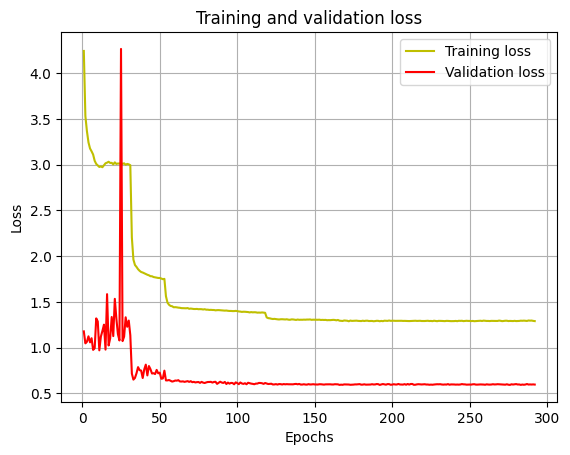

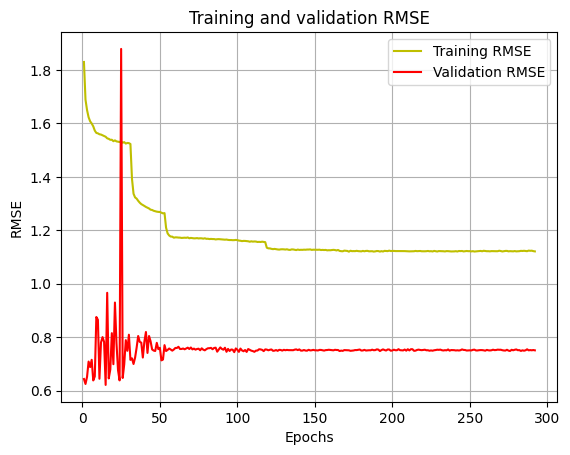

In [62]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(f"{model_path}/{formatted_datetime}_loss.png")
plt.show() # show image, create new image and set it as current

acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
plt.plot(epochs, acc, 'y', label='Training RMSE')
plt.plot(epochs, val_acc, 'r', label='Validation RMSE')
plt.title('Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.savefig(f"{model_path}/{formatted_datetime}_rmse.png")
plt.show()

In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [64]:
# # 10-fold Cross Validation
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=60)

# scores = cross_val_score(
#     estimator = regressor,
#     X = feature_matrix_X,
#     y = label_Y,
#     scoring='mse',
#     cv = kfold,
#     n_jobs = 1)
# scores

In [65]:
# # Evaluate the regressor
# Y_preds = regressor.predict([X[:,0],  X[:,2],  X[:,2]], batch_size=2024)
# print(f'Y_preds.shape: {Y_preds.shape}')